### Step 1

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from google import genai
import json
from copy import deepcopy
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

path = 'cars_info.csv'
pkl_path = 'db.pkl'
with open('key.txt', 'r') as f:
  key = f.read()

In [ ]:
# read data and preprocess
df = pd.read_csv(path)
df = df.drop(columns=['ID'])
df.drop_duplicates()

# create strings from rows
df['String'] = df.apply(lambda i: ' - '.join([f'{j} : {i[j]}' for j in df.columns]), axis=1)
docs = df['String'].tolist()
df = df.drop(columns=['String'])

In [ ]:
docs[0]

'Name : 2010 Toyota Rukus Build 2 AZE151R - Price : 9999 - Brand : Toyota - Model : Rukus - Variant : Build 2 - Series : AZE151R - Year : 2010 - Kilometers : 263000 - Type : Wagon - Gearbox : Automatic - Fuel : Unleaded Petrol - Status :  Used - CC : 2362 - Color : Grey - Seating Capacity : 5'

In [ ]:
# embedding strings
model = SentenceTransformer('all-MiniLM-L6-v2')
vecs = model.encode(docs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Test to find params

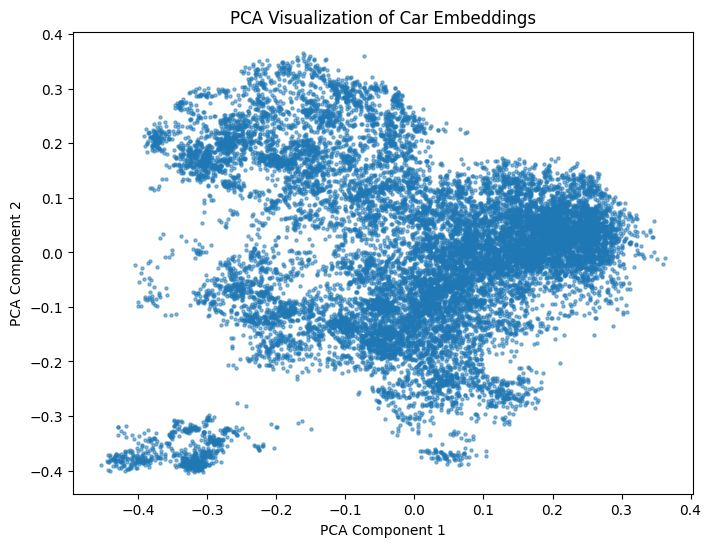

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vecs)

plt.figure(figsize=(8, 6))
plt.scatter(vecs_2d[:, 0], vecs_2d[:, 1], s=5, alpha=0.5)  # s=5: kích thước chấm, alpha=0.5: độ trong suốt
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Car Embeddings")
plt.show()

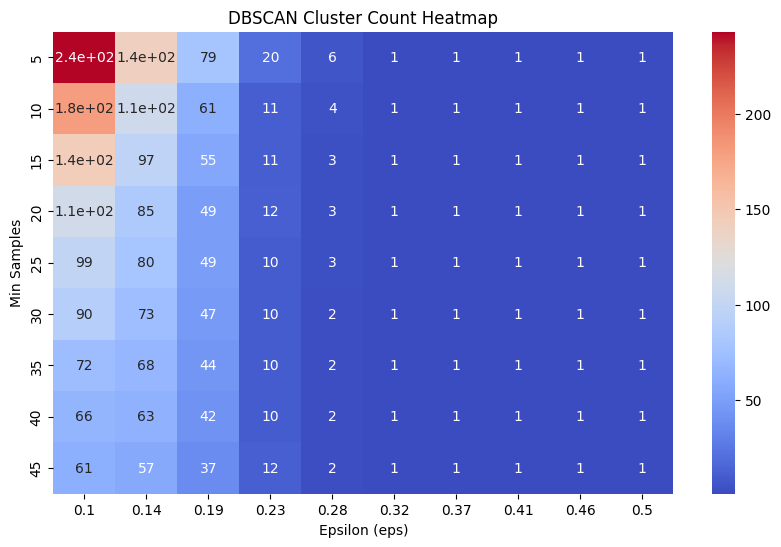

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

eps_values = np.linspace(0.1, 0.5, 10)  # 10 giá trị từ 0.1 đến 0.5
min_samples_values = np.arange(5, 50, 5)  # Từ 5 đến 50 với bước nhảy là 5
heatmap_data = np.zeros((len(min_samples_values), len(eps_values)))

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
        clusters = dbscan.fit_predict(vecs)

        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Loại bỏ nhiễu (-1)
        heatmap_data[i, j] = num_clusters

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, xticklabels=np.round(eps_values, 2), yticklabels=min_samples_values, cmap="coolwarm")
plt.xlabel("Epsilon (eps)")
plt.ylabel("Min Samples")
plt.title("DBSCAN Cluster Count Heatmap")
plt.show()

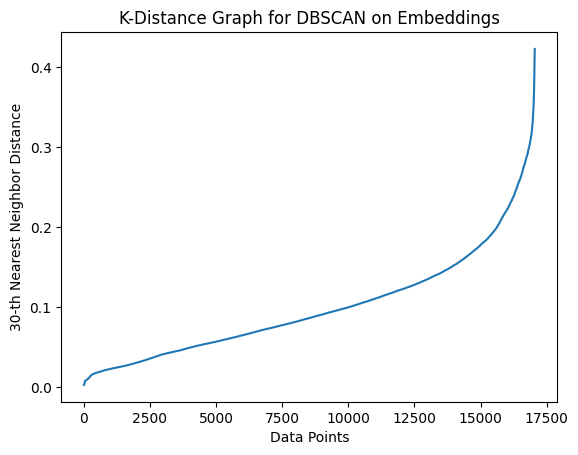

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# k = vecs.shape[1]
k = 30
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(vecs)
distances, indices = nbrs.kneighbors(vecs)
distances = np.sort(distances[:, k-1], axis=0)

plt.plot(distances)
plt.xlabel("Data Points")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph for DBSCAN on Embeddings")
plt.show()

<ipython-input-132-7419f51c4189>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


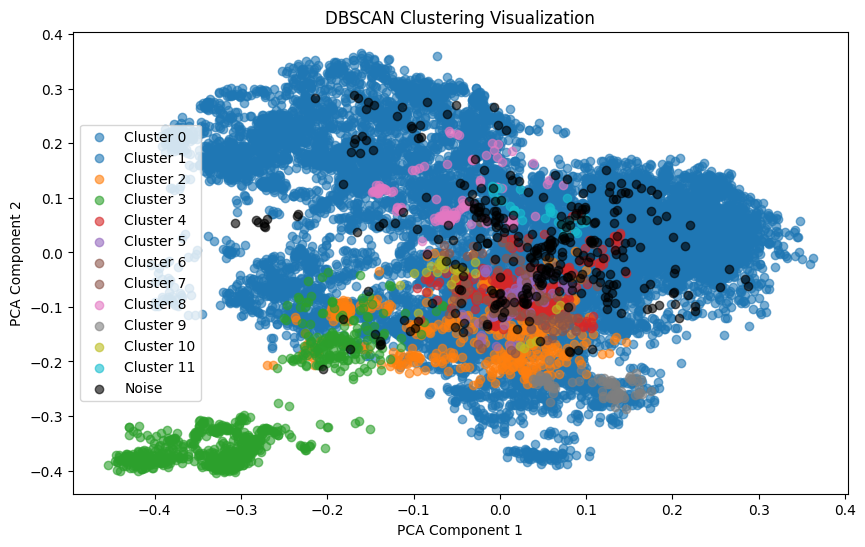

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

eps = 0.23
min_samples = 25

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
labels = dbscan.fit_predict(vecs)

pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vecs)

plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for label in unique_labels:
    if label == -1:
        color = "black"
        label_name = "Noise"
    else:
        color = colors(label)
        label_name = f"Cluster {label}"

    plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=[color], label=label_name, alpha=0.6)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization")
plt.legend()
plt.show()

### Step 2

In [ ]:
# clustering
# 0.15 - 10 - 102 clus (mainly by name)
# 0.15 - 20 - 81 clus (mainly by name)
# 0.2 - 30 - 41 clus (by name)
# 0.25 - 30 - 5 clus (first clus mix)
dbscan = DBSCAN(eps=0.25, min_samples=30, metric='cosine')
clusters = dbscan.fit_predict(vecs)
uniq_clusters = [int(i) for i in set(clusters) if i != -1]
centroids = {i: np.mean([vecs[j] for j in range(len(clusters)) if clusters[j] == i], axis=0) for i in uniq_clusters}

# rearrange data
car_clusters = {i: [(docs[j], vecs[j], df.iloc[j].to_dict()) for j in range(len(docs)) if clusters[j] == i] for i in uniq_clusters}
car_clusters = {'centroid': centroids, 'cluster': car_clusters}

In [ ]:
car_clusters['cluster'][0][0]

('Name : 2021 Mercedes-Benz V 250 D Avantgarde MWB 447 MY21 - Price : 117990 - Brand : Mercedes-Benz - Model : V - Variant : 250 D Avantgarde MWB - Series : 447 MY21 - Year : 2021 - Kilometers : 19 - Type : Wagon - Gearbox : Automatic - Fuel : Diesel - Status :  New In Stock - CC : 2143 - Color : Black - Seating Capacity : 7',
 array([-9.52255353e-02,  2.13236194e-02,  9.39226896e-03,  4.62800190e-02,
         7.18041556e-03,  3.96253839e-02,  5.26397303e-02,  8.26925635e-02,
        -8.86135269e-03, -6.14233650e-02,  2.67954171e-02, -9.24329460e-02,
         6.21651635e-02, -1.33919865e-02, -7.64309093e-02,  5.94734726e-03,
         4.61344570e-02, -7.24594891e-02, -3.46909538e-02, -2.77696569e-02,
        -1.04446612e-01,  1.16281830e-01, -4.15373780e-02,  5.49419262e-02,
        -5.29953055e-02, -3.15601788e-02, -5.36758825e-03,  6.69709295e-02,
         1.03622675e-02, -6.52527213e-02,  5.70121855e-02,  3.34146991e-02,
         4.04841863e-02,  8.77520293e-02,  5.73772117e-02, -1.2

In [ ]:
# statistic
print(f'Number of clusters: {len(set(clusters)) - 1}')
demo = {}
for i in clusters:
  if i not in demo:
    demo[int(i)] = 1
  else:
    demo[i] += 1
for i in demo.items():
  print(i)

Number of clusters: 5
(-1, 252)
(0, 16516)
(1, 97)
(2, 66)
(3, 38)
(4, 79)


In [ ]:
# show cars in cluster
for i in range(len(clusters)):
  if clusters[i] == -1:
    print(f'{docs[i]} 👉🏻 {clusters[i]}')

Name : 2010 Toyota Rukus Build 2 AZE151R - Price : 9999 - Brand : Toyota - Model : Rukus - Variant : Build 2 - Series : AZE151R - Year : 2010 - Kilometers : 263000 - Type : Wagon - Gearbox : Automatic - Fuel : Unleaded Petrol - Status :  Used - CC : 2362 - Color : Grey - Seating Capacity : 5 👉🏻 -1
Name : 2013 Ssangyong Stavic SPR 2.7 XDI A100 08 Upgrade - Price : 10990 - Brand : Ssangyong - Model : Stavic - Variant : SPR 2.7 XDI - Series : A100 08 Upgrade - Year : 2013 - Kilometers : 263542 - Type : Wagon - Gearbox : Automatic - Fuel : Diesel - Status :  Used - CC : 2696 - Color : Silver - Seating Capacity : 7 👉🏻 -1
Name : 2011 Toyota Rukus Build 3 AZE151R - Price : 16996 - Brand : Toyota - Model : Rukus - Variant : Build 3 - Series : AZE151R - Year : 2011 - Kilometers : 115857 - Type : Wagon - Gearbox : Automatic - Fuel : Unleaded Petrol - Status :  Used - CC : 2362 - Color : Black - Seating Capacity : 5 👉🏻 -1
Name : 2020 Ram 1500 Warlock (black/Grey/HYD Blue) MY20 - Price : 110990 - 

In [ ]:
# save data
with open(pkl_path, 'wb') as f:
  pickle.dump(car_clusters, f)

In [ ]:
client = genai.Client(api_key=key)
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# read saved data
with open(pkl_path, 'rb') as f:
  DATA = pickle.load(f)
CARS = DATA['cluster']
CENTROIDS = DATA['centroid']

# main funcs
def car_recommend(query):
  cars = deepcopy(CARS)
  r, q = convert_inp(query)
  cos = [(i, cosine_similarity([q], [CENTROIDS[i]])[0][0]) for i in CENTROIDS.keys()]
  cos = sorted(cos, key=lambda i: -i[1])
  cars = cars[cos[0][0]]
  cars = filter(r, cars)
  cars = rcm(q, cars)
  cars = rank(query, cars[:10])
  for i, j in enumerate(cars):
    print(f"{i+1}. {j.get('car', '')}")
    print(f"Reason: {j.get('reason', '')}\n")

def convert_inp(query):
  if query.strip() == '':
    return [], np.zeros(384)
  prompt = f"""I have these criteria: ['Name', 'Price', 'Brand', 'Model', 'Variant', 'Series', 'Year', 'Kilometers', 'Type', 'Gearbox', 'Fuel', 'Status', 'CC', 'Color', 'Seating Capacity']
  Convert this sentence: '{query.lower()}' to JSON with pairs of 'key : value'. If exist any criteria not in the list above, ignore it. With number value, add operator ( >, =, <)
  Use this JSON schema:
  Pair = 'key': str, 'value': str, 'op': str (optional)
  Return: list[Pair]"""
  response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
  r = json.loads(response.text.replace('```json', '').replace('```', ''))
  s = ' - '.join([f"{i['key']} : {i['value']}" for i in r if i['key'] not in ['Price', 'Year', 'Kilometers', 'CC', 'Seating Capacity']]).lower()
  # s = ' - '.join([f"{i} : {rr.get(i, ' ')}" if i not in ['Price', 'Year', 'Kilometers', 'CC', 'Seating Capacity'] else f"{i} : " for i in ['Name', 'Price', 'Brand', 'Model', 'Variant', 'Series', 'Year', 'Kilometers', 'Type', 'Gearbox', 'Fuel', 'Status', 'CC', 'Color', 'Seating Capacity']]).lower()
  q = model.encode(s) if s.strip() != '' else np.zeros(384)
  return r, q

def rank(query, cars):
  if len(cars) <= 0:
    return []
  _cars = [i[0] for i in cars]
  prompt = f"""Based on user'criteria in this query: '{query}', rank this list descending and return JSON list: {_cars}. For each car, add a reason to persuade user to buy it in only 1 sentence. Remain EXACTLY {len(_cars)} items
  Use this JSON schema:
  Result = 'car': str, 'reason': str
  Return: list[Result]"""
  response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
  r = json.loads(response.text.replace('```json', '').replace('```', ''))
  return r

def filter(r, cars):
  filters = []
  for i in r:
    if 'op' in i and i['key'] in ['Price', 'Year', 'Kilometers', 'CC', 'Seating Capacity'] and i['value'][0].isalpha():
      try:
        _ = float(i['value'])
        if i['op'] == '>':
          filters.append(lambda x: x[2][i['key']] > float(i['value']))
        elif i['op'] == '<':
          filters.append(lambda x: x[2][i['key']] < float(i['value']))
        elif i['op'] == '<=':
          filters.append(lambda x: x[2][i['key']] <= float(i['value']))
        elif i['op'] == '>=':
          filters.append(lambda x: x[2][i['key']] >= float(i['value']))
        elif i['op'] == '=':
          filters.append(lambda x: 0.75 <= (x[2][i['key']] / float(i['value'])) <= 1.25)
      except ValueError:
        continue
  # return list(filter(lambda x: all([i(x) for i in filters]), cars))
  return [i for i in cars if all([j(i) for j in filters])]

def rcm(q, cars):
  if len(cars) == 0:
    return []
  cos = cosine_similarity([q], [i[1] for i in cars]).flatten()
  cars = [(cars[i][0], cos[i]) for i in range(len(cars))]
  cars = sorted(cars, key=lambda i: -i[1])
  return cars

In [ ]:
car_recommend('a silver Mazda cheaper than 20000, automatic gearbox')

1. 2006 Mazda 6 Luxury GG 05 Upgrade - Price : 7990 - Brand : Mazda - Model : 6 - Variant : Luxury - Series : GG 05 Upgrade - Year : 2006 - Kilometers : 153253 - Type : Hatchback - Gearbox : Automatic - Fuel : Premium Unleaded Petrol - Status :  Used - CC : 2261 - Color : Silver - Seating Capacity : 5
Reason: Enjoy a comfortable and stylish ride with this silver Mazda 6 Luxury hatchback, offering an automatic transmission at an affordable price.

2. 2010 Mazda 3 MPS BL - Price : 11500 - Brand : Mazda - Model : 3 - Variant : MPS - Series : BL - Year : 2010 - Kilometers : 230000 - Type : Hatchback - Gearbox : Manual - Fuel : Premium Unleaded Petrol - Status :  Used - CC : 2261 - Color : Silver - Seating Capacity : 5
Reason: This silver Mazda 3 MPS offers sporty performance and practicality at a great value, perfect for those seeking a fun driving experience.

3. 2008 Mazda 6 Classic GH - Price : 8990 - Brand : Mazda - Model : 6 - Variant : Classic - Series : GH - Year : 2008 - Kilometers